# Knowledge based visual question answering Demo

All the files required to run this ipython notebook can be obtained from (private repo for now)
### https://github.com/i-am-SR/KBVQA

This notebook extends the work from this repo:
### https://github.com/iamaaditya/VQA_Demo

## Load the libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import os, argparse
import cv2, spacy, numpy as np
from keras.models import model_from_json
from keras.optimizers import SGD
from sklearn.externals import joblib
from keras import backend as K
from keras.utils.vis_utils import plot_model
K.set_image_data_format('channels_first')
#K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [0]:
#not required if tf version is correct. If used, restart runtime
!pip install tensorflow==1.15.0

In [0]:
#not required if keras version is correct. If used, restart runtime
!pip install keras==2.1.0

In [2]:
import keras; print(keras.__version__);
import tensorflow as tf; print(tf.__version__)
#check if keras is 2.1.0 and tf is 1.15.0

2.1.0
1.15.0


In [0]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

## Load the models and weights files
This does not load the models yet, but we are providing the files


In [4]:
#navigate to where models folder is
%cd /content/drive/My\ Drive/

/content/drive/My Drive


In [0]:
# File paths for the model, all of these except the CNN Weights are 
# provided in the repo, See the models/CNN/README.md to download VGG weights
VQA_model_file_name      = 'models/VQA/VQA_MODEL.json'
VQA_weights_file_name   = 'models/VQA/VQA_MODEL_WEIGHTS.hdf5'
label_encoder_file_name  = 'models/VQA/FULL_labelencoder_trainval.pkl'
CNN_weights_file_name   = 'models/CNN/vgg16_weights.h5'
#Query_file_name   =  'models/QueryEngines.py'
Query_file_name   =  'models/Query.py'


In [0]:
#not required
import py_compile
py_compile.compile(Query_file_name)

In [9]:
!pip install SPARQLWrapper

     |████████████████████████████████| 819kB 11.5MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
  Created wheel for rdflib: filename=rdflib-5.0.0-cp27-none-any.whl size=231056 sha256=3233504123a8272bc45a887154f73a87b0946c595236472f0f8e10d9be981b71
  Stored in directory: /root/.cache/pip/wheels/58/57/e4/4a5e85b1da1733fe7ba875422668b1fd736dbc3c3854243d9d
Successfully built rdflib


In [0]:
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
#from models.QueryEngines import CommonProp, AnimalClass, TellMeAbout, SportEquip, AnimalSame, FoodIngredient, IsTheA, SelectPropertyQueryEngine, SelectQueryEngine, AskQueryEngine
from models.Query import CommonProp, AnimalClass, TellMeAbout, SportEquip, AnimalSame, FoodIngredient, IsTheA, SelectPropertyQueryEngine, SelectQueryEngine, AskQueryEngine

## Model Idea
This uses a classical CNN-LSTM  model like shown below, where Image features and language features are computed separately and combined together and a multi-layer perceptron is trained on the combined features.

Similar models have been presented at following links, this work takes ideas from them.
1. <https://github.com/abhshkdz/neural-vqa>
2. <https://github.com/avisingh599/visual-qa>
3. https://github.com/VT-vision-lab/VQA_LSTM_CNN


<img src="http://i.imgur.com/Za5P1ZZ.png">
[Source](http://arxiv.org/pdf/1505.00468v4.pdf)

# Image features 

## Pretrained VGG Net (VGG-16)

While VGG Net is not the best CNN model for image features, GoogLeNet (winner 2014) and ResNet (winner 2015) have superior classification scores, but VGG Net is very versatile, simple, relatively small and more importantly portable to use. 

For reference here is the VGG 16 performance on ILSVRC-2012
<img src="http://www.robots.ox.ac.uk/~vgg/research/very_deep/images/table_ILSVRC.png">

## Compile the model

In [0]:
def get_image_model(CNN_weights_file_name):
    ''' Takes the CNN weights file, and returns the VGG model update 
    with the weights. Requires the file VGG.py inside models/CNN '''
    from models.CNN.VGG import VGG_16
    image_model = VGG_16(CNN_weights_file_name)
    image_model.layers.pop()
    image_model.layers.pop()
    # this is standard VGG 16 without the last two layers
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    # one may experiment with "adam" optimizer, but the loss function for
    # this kind of task is pretty standard
    image_model.compile(optimizer=sgd, loss='categorical_crossentropy')
    return image_model

## Plot the Model

Keras has a function which allows you to visualize the model in block diagram. Let's do it !

In [0]:
from IPython.display import Image

In [13]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
model_vgg = get_image_model(CNN_weights_file_name)
plot_model(model_vgg, to_file='model_vgg.png')

W0513 21:55:35.592073 139813974837120 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:63: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0513 21:55:35.599461 139813974837120 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:492: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0513 21:55:35.615339 139813974837120 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3630: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0513 21:55:35.625595 139813974837120 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:158: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0513 21:55:35.627212 139813974837120 module_wrapper

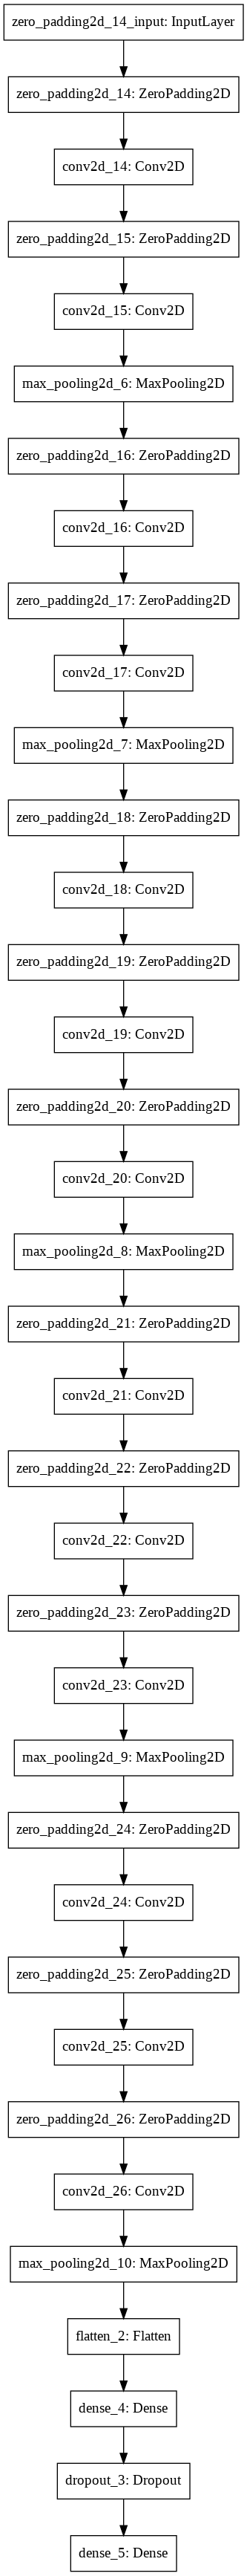

In [0]:
Image('model_vgg.png')

<img src="model_vgg.png">

## Extract Image features


Extracting image features involves, taking a raw image, and running it through the model, until we reach the last layer. In this case our model is not 100% same as VGG Net, because we are not going to use the last two layer of the VGG. It is because the last layer of VGG Net is a 1000 way softmax and the second last layer is the Dropout.

Thus we are extracting the 4096 Dimension image features from VGG-16


In [0]:
def get_image_features(image_file_name):
    ''' Runs the given image_file to VGG 16 model and returns the 
    weights (filters) as a 1, 4096 dimension vector '''
    image_features = np.zeros((1, 4096))
    # Magic_Number = 4096  > Comes from last layer of VGG Model

    # Since VGG was trained as a image of 224x224, every new image
    # is required to go through the same transformation
    im = cv2.resize(cv2.imread(image_file_name), (224, 224))
    im = im.transpose((2,0,1)) # convert the image to RGBA

    
    # this axis dimension is required because VGG was trained on a dimension
    # of 1, 3, 224, 224 (first axis is for the batch size
    # even though we are using only one image, we have to keep the dimensions consistent
    im = np.expand_dims(im, axis=0) 

    image_features[0,:] = model_vgg.predict(im)[0]
    return image_features

# Word Embeddings

The question has to be converted into some form of word embeddings. Most popular is Word2Vec whereas these days state of the art uses [skip-thought vectors](https://github.com/ryankiros/skip-thoughts) or [positional encodings](https://en.wikipedia.org/wiki/Encoding_(memory).

We will use Word2Vec from Stanford called [Glove](http://nlp.stanford.edu/projects/glove/). Glove reduces a given token into a 300 dimensional representation.

In [0]:
def get_question_features(question):
    ''' For a given question, a unicode string, returns the time series vector
    with each word (token) transformed into a 300 dimension representation
    calculated using Glove Vector '''
    word_embeddings = spacy.load('en_vectors_web_lg')
    #word_embeddings = spacy.load('en', vectors='en_glove_cc_300_1m_vectors')
    tokens = word_embeddings(question)
    question_tensor = np.zeros((1, 30, 300))
    #question_tensor = np.zeros((1, len(tokens), 300))
    for j in xrange(len(tokens)):
        question_tensor[0,j,:] = tokens[j].vector
    return question_tensor

# **Testing Wikidata queries**

In [0]:
url = 'https://query.wikidata.org/sparql'
query1= """
SELECT DISTINCT ?horse ?attr ?attrLabel WHERE {
?horse (wdt:P31/(wdt:P279*)) wd:"""

obj='Q870'

query2=''';
wdt:'''
      
attribute='P571'
rest=""" ?attr.
SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
ORDER BY ASC (?attr)"""
query=query1+obj+query2+attribute+rest

r = requests.get(url, params = {'format': 'json', 'query': query})
data = r.json()
#attributes={'introduced':'P571'}
#items={'train':"Q870"}

attributes={'introduced':'P571','made_of':'P186','length':"P2043",'color':"P462", 'ingredient': "P527"}
items={'train':"Q870" ,'car':"Q1420",'dog':"Q144",'laptop': "Q3962", 'pasta':"Q178", 'fries': "Q152088", 'pizza':"Q177"}

def introduction(objects):
    q=query1+items[objects]+query2+attributes['introduced']+rest
    r = requests.get(url, params = {'format': 'json', 'query': q}) 
    data = r.json()
    print '{0} was introduced in '.format(objects)
    if len(data['results']['bindings']) <= 0:
        print '[no matches found]'
    else:
        print data['results']['bindings'][0]['attrLabel']['value'][0:4]

def Length(objects):
    q=query1+items[objects]+query2+attributes['length']+rest
    r = requests.get(url, params = {'format': 'json', 'query': q}) 
    data = r.json()
    print 'The average length of {0}'.format(objects)
    if len(data['results']['bindings']) <= 0:
        print '[no matches found]'
    else:
        print '{0} units'.format(data['results']['bindings'][1]['attrLabel']['value'])
def Color(temp):
    q=query1+items[temp]+query2+attributes['color']+rest
    r = requests.get(url, params = {'format': 'json', 'query': q}) 
    data = r.json()
    result = {u'black'}
    print 'Other colors for {0} are '.format(temp)
    if len(data['results']['bindings']) <= 0:
        print '[no matches found]'
    for i in range(len(data['results']['bindings'])):
        print data['results']['bindings'][i]['attrLabel']['value']

def Made(temp):
    q=query1+items[temp]+query2+attributes['made_of']+rest
    r = requests.get(url, params = {'format': 'json', 'query': q}) 
    data = r.json()
    print '{0} is made of '.format(temp)
    if len(data['results']['bindings']) <= 0:
        print '[no matches found]'
    for i in range(len(data['results']['bindings'])):
        print data['results']['bindings'][i]['attrLabel']['value']
    
    

## Try the embeddings

Let's see the embeddings, and their usage with sample words like this -
1. Obama 
2. Putin
3. Banana
4. Monkey

In [0]:
word_embeddings = spacy.load('en', vectors='en_glove_cc_300_1m_vectors')

In [0]:
obama = word_embeddings(u"obama")
putin = word_embeddings(u"putin")
banana = word_embeddings(u"banana")
monkey = word_embeddings(u"monkey")

In [0]:
obama.similarity(putin)

W0430 08:32:29.445431 139908194699136 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/tensorflow_estimator/python/estimator/api/_v1/estimator/__init__.py:12: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.



0.4547074384807158

In [0]:
obama.similarity(banana)

0.39861109091257096

In [0]:
banana.similarity(monkey)

0.7429797182900746

As we can see, obama and putin are very similar in representation than obama and banana. This shows you there is some semantic knowledge of the tokens embedded in the 300 dimensional representation. We can do cool arithmatics with these word2vec like 'Queen' - 'King' + 'Boy' = 'Girl'. See [this blog post](http://multithreaded.stitchfix.com/blog/2015/03/11/word-is-worth-a-thousand-vectors/) for more details.

In [0]:
def KB(question, obj):
    temp = obj
    if 'common' in question:
        obj2 = question[question.index('and')+4:-1]
        CommonProp(temp, obj2)
    elif 'class' in question:
        AnimalClass(temp)
    elif 'about' in question:
        TellMeAbout(temp)
    elif 'equipment' in question:
        SportEquip(temp)
    elif 'taxonomy' in question:
        obj2 = question[question.index('as')+3:-1]
        AnimalSame(temp, obj2)
    elif 'introduced' in question:
        introduction(temp)
    elif 'ingredients' in question:
        FoodIngredient(temp)
    elif 'length' in question:
        Length(temp)
    elif 'concept' in question:
        obj2 = question[question.index('of')+3:-1]
        IsTheA(temp, obj2)
    elif 'color' in question:
        Color(temp)
    elif 'made of' in question:
        Made(temp)
    else:
        print 'We can\'t answer such questions. Its not a part of out templates'
    



## VQA Model

VQA is a simple model which combines features from Image and Word Embeddings and runs a multiple layer perceptron.

In [0]:
def get_VQA_model(VQA_model_file_name, VQA_weights_file_name):
    ''' Given the VQA model and its weights, compiles and returns the model '''

    # thanks the keras function for loading a model from JSON, this becomes
    # very easy to understand and work. Alternative would be to load model
    # from binary like cPickle but then model would be obfuscated to users
    vqa_model = model_from_json(open(VQA_model_file_name).read())
    vqa_model.load_weights(VQA_weights_file_name)
    vqa_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')
    return vqa_model

In [0]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
model_vqa = get_VQA_model(VQA_model_file_name, VQA_weights_file_name)
plot_model(model_vqa, to_file='model_vqa.png')

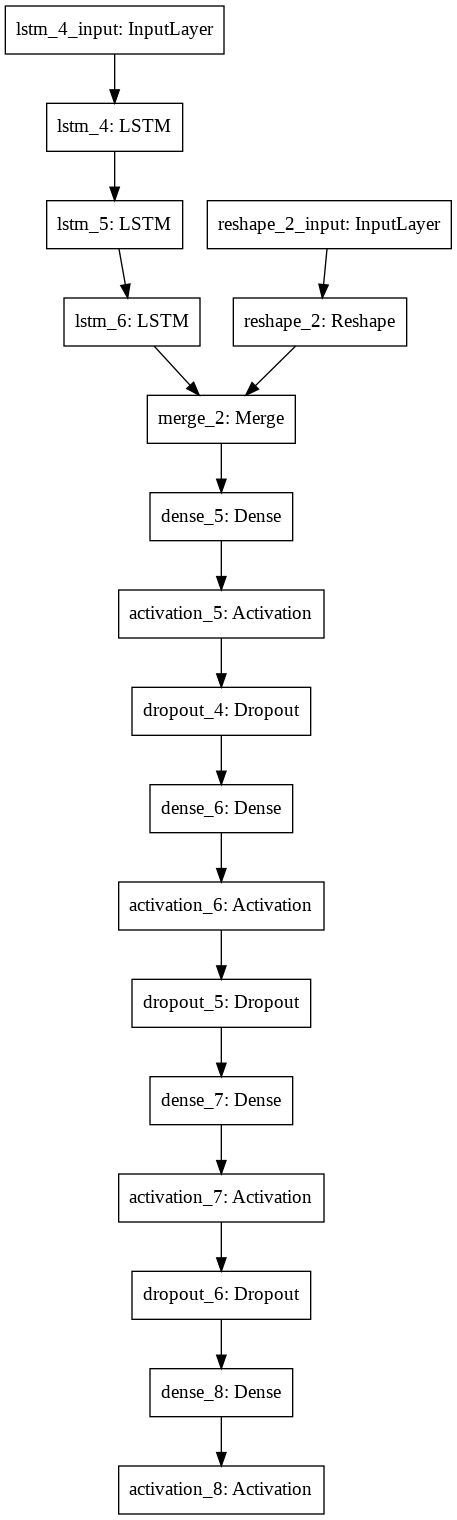

In [0]:
Image('model_vqa.png')

<img src="model_vqa.png">

As it can be seen above the model also runs a 3 layered LSTM on the word embeddings. To get a naive result it is sufficient to feed the word embeddings directly to the merge layer, but as mentioned above model is gives close to the state-of-the-art results.

Also, four layers of fully connected layers might not be required to achieve a good enough results. But I settled on this model after some experimentation, and their results beat few layers. 

In [3]:
!python -m spacy download "en_vectors_web_lg"

     |████████████████████████████████| 661.8MB 3.9MB/s 
  Created wheel for en-vectors-web-lg: filename=en_vectors_web_lg-2.1.0-cp27-none-any.whl size=663461748 sha256=10e9d655210ba687d0af447bcdc107a88470de0d9e68abfd1d36b6cd9a2e1dda
  Stored in directory: /tmp/pip-ephem-wheel-cache-2K4MzY/wheels/ce/3e/83/59647d0b4584003cce18fb68ecda2866e7c7b2722c3ecaddaf
Successfully built en-vectors-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_vectors_web_lg')


In [0]:
def object_detection(image_file_name):
    question = ""
    if 'sport' in image_file_name:
        question = u"What sport are they playing?"
    else:
        question = u"What object is in the picture?"
    image_features = get_image_features(image_file_name)
    question_features = get_question_features(question)
    y_output = model_vqa.predict([question_features, image_features])

    # This task here is represented as a classification into a 1000 top answers
    # this means some of the answers were not part of training and thus would 
    # not show up in the result.
    # These 1000 answers are stored in the sklearn Encoder class
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    labelencoder = joblib.load(label_encoder_file_name)
    i = 0
    for label in reversed(np.argsort(y_output)[0,-5:]):
        #print str(round(y_output[0,label]*100,2)).zfill(5), "% ", labelencoder.inverse_transform(np.array([label]))[0]
        if i == 0:
          temp = labelencoder.inverse_transform(np.array([label]))[0]
        i += 1
    print temp
    return temp

<img src="test.jpg">

# <center> Ask your question regarding the image </center>

## **The templates for our model:**

'What is common between the object and cat?' 

'What is the class of the animal?'

'tell me about the object?'

'what is the object made of?'

'what are the ingredients of this food?'

'what is the length of the object?'

'when was the object introduced?'

# **Ask the question about the image that you need an answer to?**

In [21]:
#Ask a question to the KBVQA model:
#question='What is common between the dog and cat?' 
#question='What is the class of the animal?'
question='tell me about the object?'
#question='what is the object made of?'
#question='what are the ingredients of this food?'
#question= 'what is the length of the object?'
#question='when was the object introduced?'
image_file_name = 'dog.jpg'
obj = object_detection(image_file_name)

dog


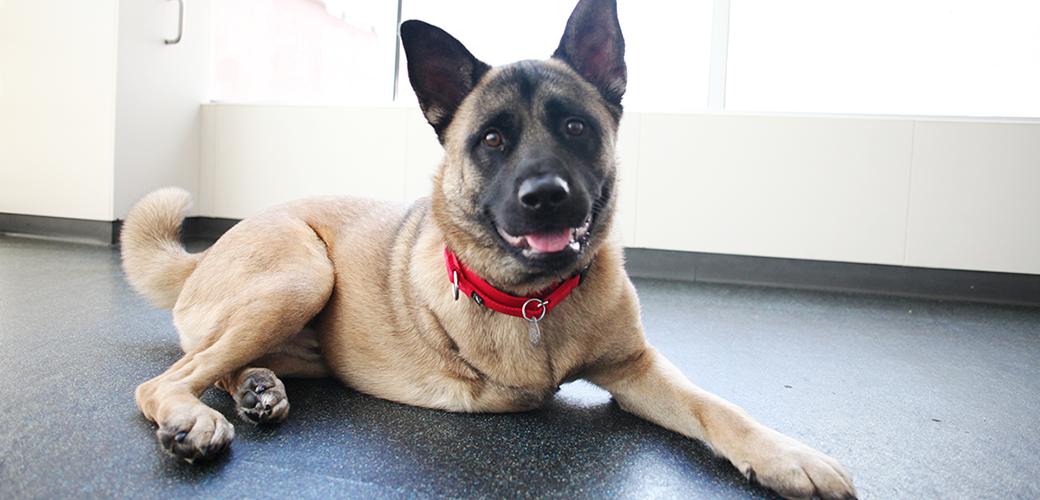

In [22]:
Image(image_file_name)

In [0]:
#temp = cake

# **Output of your query**

In [23]:
KB(question, obj)

The following is a little stuff about dog:
	The domestic dog (Canis lupus familiaris or Canis familiaris) is a domesticated canine which has been selectively bred over millennia for various behaviours, sensory capabilities, and physical attributes. Although initially thought to have originated as an artificial variant of an extant canid species (variously supposed as being the dhole, golden jackal, or gray wolf), extensive genetic studies undertaken during the 2010s indicate that dogs diverged from an extinct wolf-like canid in Eurasia 40,000 years ago. Their long association with humans has led to dogs being uniquely attuned to human behavior and are able to thrive on a starch-rich diet which would be inadequate for other canid species. Dogs are also the oldest domesticated animal. Dogs vary widely in shape, size and colours. Dogs perform many roles for people, such as hunting, herding, pulling loads, protection, assisting police and military, companionship and, more recently, aiding 

!
!
!
!
!
!































